# D) ENMO Méthode

# Préparation des données

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/HAH913E-2024-projet/AX3 Project/Sans titre/data/NoneSmokerCardio.csv"

data = pd.read_csv(file_path)

# Renommer les colonnes 
data.columns = ['Temps', 'X', 'Y', 'Z']


timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # Colonnes correspondant au X,Y,Z de notre signal enregistré. 

# Conversion de la colonne temps en datatime de panda
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Gestion des données de temps manquantes 

# Calcule de l'intervalle d'échantillonage en secondes 
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()

# Créer une nouvelle colonne "relative_time_minutes" qui représente le temps écoulé depuis le début de la mesure.
data['relative_time_minutes'] = data.index * sampling_interval

# Légende
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'skyblue', 'Y': 'orange', 'Z': 'lightgreen'}  

####  Application d'un offset de calibraiton 

Cette offset permet une correction des données brutes afin de recentrer les valeurs autour de leurs bases attendues. Dans le cas de notre Accéleromètre, pour les axes X/Y les valeurs devraient osciller autour de 0g au repos car ces axes ne mesurent pas la gravité. Tandis que l'axe Z lui devrait être centré autour de 1g (position verticale), il mesure lui la gravité terrestre. Il permet ainsi de corriger le biais constant dans nos données. 

Cette calibration permet de corriger : 
- les éventuelles erreurs de fabrication ou alignement. 
- les erreurs de positionnement
- le bruit mécanique : dans notre cas vibration d'un tapis roulant. 

In [8]:

#Le capteur n'est pas calibré correctement ainsi on applique un offset pour chacun de nos axes.

calibration_offset = {
    'X': -1.62,   # Offset pour l'axe X
    'Y': -0.88,    # Offset pour l'axe Y
    'Z': -1.16    # Offset pour l'axe Z
}
for col, offset in calibration_offset.items():
    data[col] = data[col] - offset

from scipy.signal import butter, filtfilt

#  Définition d'un filtre passe-bas Butterworth permettant de réduire le bruit ( supprimer les hautes fréquences)
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequence
    normal_cutoff = cutoff / nyquist # La fréquence de coupure est normalisée par rapport à la fréquence de Nyquist pour être utilisée par le filtre.
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data) #Applique le filtre dans les deux directions (avant et arrière) pour éviter les déphasages et produire un signal lissé.

# Application du filtre sur chaque colonne de signal
fs = 1 / sampling_interval  # Fréquence d'échantillonnage en Hz
cutoff = 2  # Fréquence de coupure en Hz
for col in signal_columns:
    data[col] = lowpass_filter(data[col], cutoff, fs)

# Application et Visualisation de l'ENMO 

Les données comprennent les accelérations mesurées dans les trois axes spatiaux ( X, Y et Z).
Ces trois composantes vont être combinées afin de calculer une valeur unique représentant l'intensité totale de l'accélération, c'est la Norme enclidienne. 

L'ENMO est une métrique utilisée dans l'analyse des données d'accéléromètres. Elle permet de mesurer l'excès de mouvement par rapport à une valeur seuil (ici, 1). Si la norme normalisée est inférieure ou égale à 1, l'ENMO est définie comme 0 (pas de mouvement excessif).

l'ENMO est utilisé comme indicateur d’intensité : 
- ENMO = ou proche de 0 : pas de mouvement.
- ENMO élevée = activité physique intense.

Cette donnée permet de réaliser un classement de l'activité de l'individus selon les niveaux d'activités : Sédentaire, légère, modérée ou intense.

   relative_time_minutes  ENMO
0                  0.000   0.0
1                  0.002   0.0
2                  0.004   0.0
3                  0.006   0.0
4                  0.008   0.0


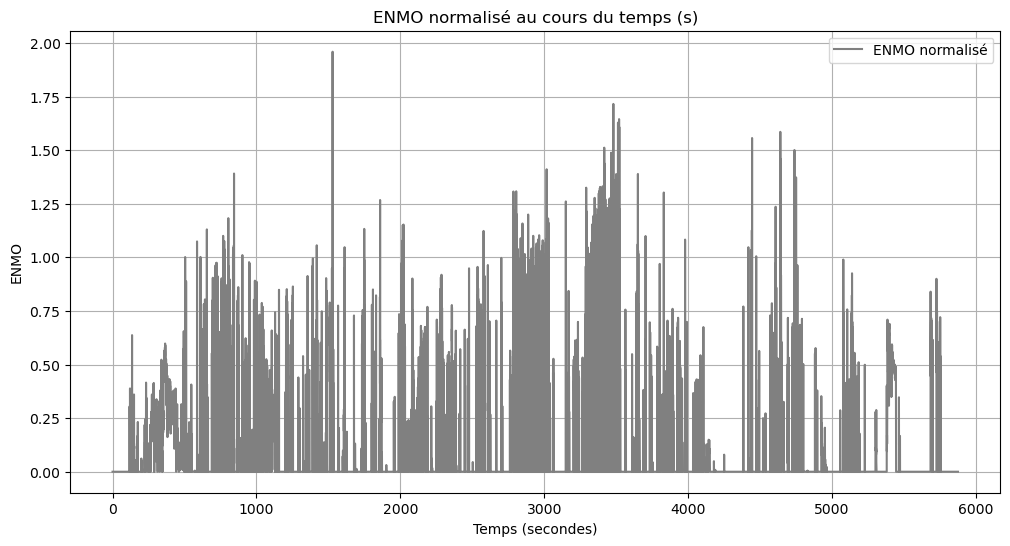

In [21]:
import numpy as np

# Calcul de la norme euclidienne des accélérations (X, Y, Z)
data.loc[:, 'norm'] = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

# Normalisation : centrer et réduire les données
mean_norm = data['norm'].mean()
std_norm = data['norm'].std()
data.loc[:, 'norm_normalized'] = (data['norm'] - mean_norm) / std_norm
# Les données sont centrées (moyenne égale à 0) et réduites (écart-type égal à 1). 
# Afin de centrer les valeurs, on leurs soustrait la moyenne de chaque valeurs. 
# Pour la réduction, on divise par l'écart-type (std_normstd_norm).

# Calcul de l'ENMO : norme normalisée - 1, et on garde la valeur maximale entre 0 et la norme
data.loc[:, 'ENMO'] = np.maximum(data['norm_normalized'] - 1, 0)

# Affichage des premiers résultats
print(data[['relative_time_minutes', 'ENMO']].head())

# Visualisation de l'ENMO normalisé
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO normalisé", color='grey')
plt.title("ENMO normalisé au cours du temps (s)")
plt.xlabel("Temps (secondes)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

A) Description des plages d’intensité : 

1) Activités faibles / Inactivités : 
--> ENMO < 0.1   

2) Activités modérées (marche rapide):
--> 0.5 < ENMO < 1.5

3) Activités intenses (sprint): 
--> 1.5 < ENMO < 3

L'activité faibles/ Inactivités vont être exclus de l'analyse principale afin de mieux différencier les efforts modérés et intenses.

B) Seuils choisis:

Pour distinguer clairement les trois types d’effort:

	1.	ENMO ≤ 0.5 : Activités faibles ou inactives (à exclure de l’analyse principale).

	2.	0.5 < ENMO ≤ 1.5 : Activités modérées (marche rapide).
	
	3.	ENMO > 1.5 : Activités intenses (sprint).

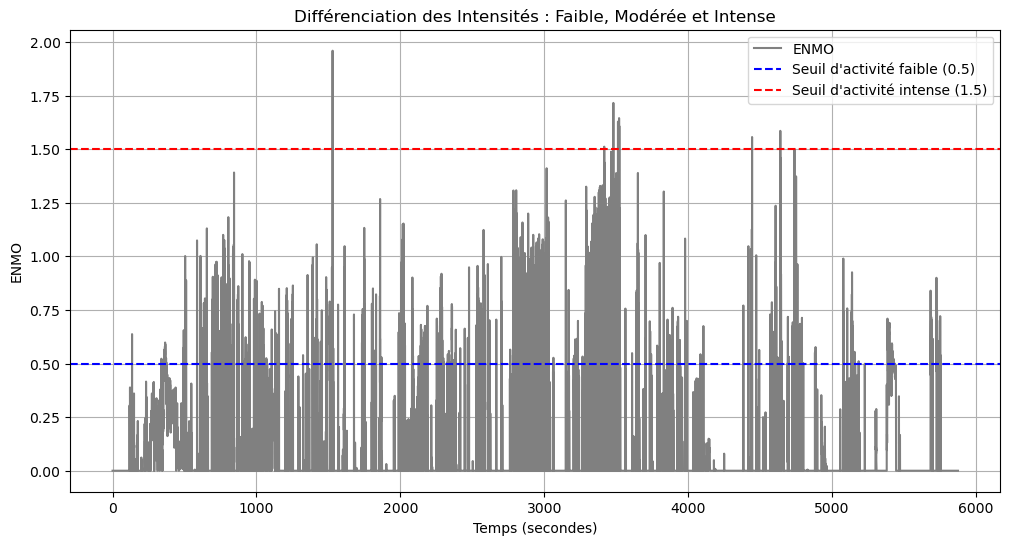

In [32]:
# Définir les seuils pour les intensités
seuil_faible = 0.5
seuil_intense = 1.5

# Classifier les moments d'intensité
moments_faibles = data[data['ENMO'] <= seuil_faible]
moments_moderes = data[(data['ENMO'] > seuil_faible) & (data['ENMO'] <= seuil_intense)]
moments_intenses = data[data['ENMO'] > seuil_intense]

# Visualisation des intensités
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO", color='grey')
plt.axhline(y=seuil_faible, color='blue', linestyle='--', label="Seuil d'activité faible (0.5)")
plt.axhline(y=seuil_intense, color='red', linestyle='--', label="Seuil d'activité intense (1.5)")
plt.title("Différenciation des Intensités : Faible, Modérée et Intense")
plt.xlabel("Temps (secondes)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

Nous observons seulement deux phases d'activités intenses indiquant ainsi une activité modérée au cours de cette enregistrement avec deux phases intenses une au départ puis au cours de l'exercice. 

# Statistiques descriptives du signal ENMO 

In [11]:
# Statistiques de base
stats = data['ENMO'].describe()
print(stats)

count    2.937599e+06
mean     7.381421e-02
std      1.867790e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.959205e+00
Name: ENMO, dtype: float64


##### Commentaires : 

La moyenne de l’ENMO est d’environ 0.0738 (g), ainsi les mouvements au dela de 1g sont très faible dans cette data. Ceci peut indiquer un faible niveau d'activité global. 

L’écart-type est d’environ 0.1867 (g). Cette faible valeur d'écart-type indique que les valeurs de l'ENMO sont concentrées autour de la moyenne et met en évidence une activité relativement uniforme avec peu de moment de grande intensité. 


# Analyse des Époques de l'activité 

On regroupe les données en intervalles de temps fixes (par exemple, 1 seconde ou 5 secondes). Pour chaque intervalle (ou époque), on calcule la moyenne des données.

1.	Échantillonnage très fin :

On souhaite créer des intervalles très court, on définit donc une époque de 0.1 seconde, ce qui reflète des variations très rapides. Cela permet de capturer des détails très fins dans les mouvements ou les variations d’accélération. Une grande précision temporelle est utile pour des activités comme le sprint.

Statistiques des époques :
count    118.000000
mean       0.073504
std        0.092183
min        0.000000
25%        0.007586
50%        0.030654
75%        0.117138
max        0.407132
Name: ENMO, dtype: float64


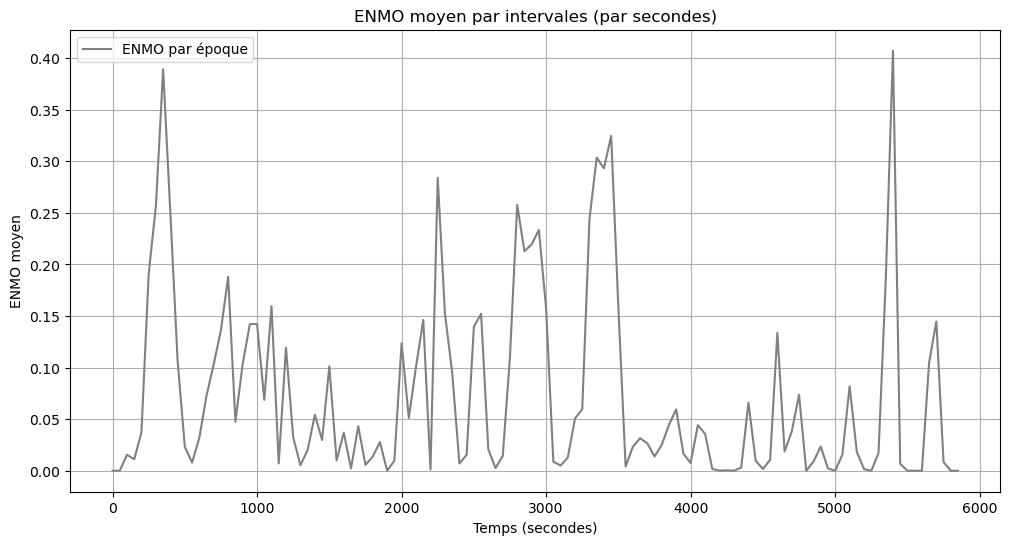

In [19]:
# Regrouper par époques (par exemple, 1 seconde)
epoch_duration = 0.1 / sampling_interval  # Durée d'une époque en secondes
data['epoch_index'] = (data['relative_time_minutes'] // epoch_duration).astype(int)  # Index des époques

# Calculer la moyenne de l'ENMO pour chaque époque
epoch_means = data.groupby('epoch_index')['ENMO'].mean()

# Afficher les résultats
print("Statistiques des époques :")
print(epoch_means.describe())

# Visualiser l'ENMO par époques
plt.figure(figsize=(12, 6))
plt.plot(epoch_means.index * epoch_duration, epoch_means, label="ENMO par époque", color='grey')
plt.title("ENMO moyen par intervalles (par secondes)")
plt.xlabel("Temps (secondes)")
plt.ylabel("ENMO moyen")
plt.grid(True)
plt.legend()
plt.show()

 Ces statistiques décrivent le comportement moyen de l'activité physique au cours des 118 intervalles définient. La moyenne étant faible ceci indique une activité faible, l'ecart-type faible lui indique une concentrationd des valeurs autour de la moyenne et donc une activité uniforme. 

Étude des quartiles : 

- 25 % des époques ont une valeur d'ENMO inférieure ou égale à 0.0076 (g) : Une proportion importante des intervalles correspond à une activité quasi nulle ou très faible.
- 50 % (Médiane) : La moitié des époques ont une valeur d'ENMO inférieure ou égale à 0.0307 (g).: Prépondérance d'activités légères ou de repos dans nos données.
- 75 % des époques ont une valeur d'ENMO inférieure ou égale à 0.1171 (g). Seules 25 % des époques correspondent à des niveaux d'activité modérés ou plus élevés. 

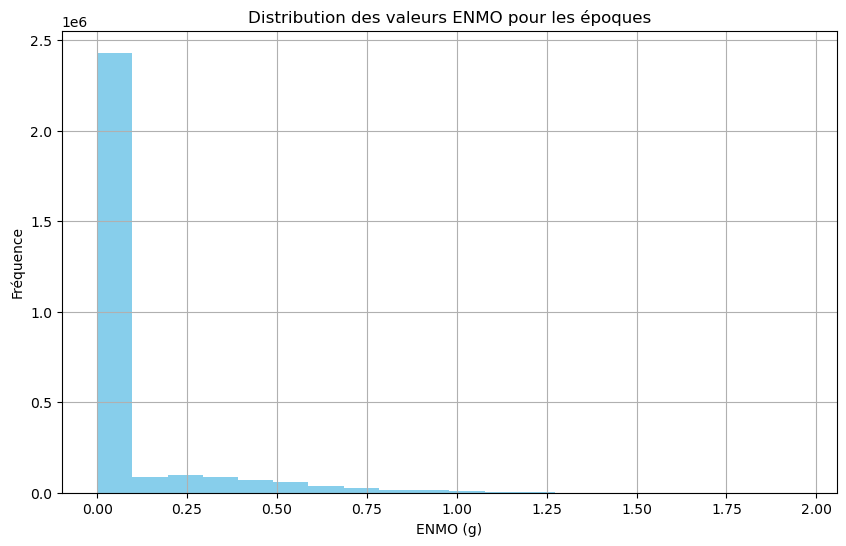

In [33]:
data['ENMO'].hist(bins=20, figsize=(10, 6), color='skyblue')
plt.title("Distribution des valeurs ENMO pour les époques")
plt.xlabel("ENMO (g)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [23]:
active_epochs = (data['ENMO'] > 0.1).mean() * 100
print(f"Pourcentage d'époques actives : {active_epochs:.2f}%")


Pourcentage d'époques actives : 17.14%


# Estimation du Rythme cardiaque grâce à l'ENMO 


In [13]:
# Fonction d'estimation du rythme cardiaque en fonction de l'ENMO
def estimate_heart_rate(enmo):
    """
    Estime le rythme cardiaque en fonction de l'ENMO.
    """
    if enmo <= 0.5:
        return 100 + enmo * 40  # Rythme cardiaque pour marche rapide (~100-120 BPM)
    elif enmo <= 1.0:
        return 120 + (enmo - 0.5) * 80  # Transition marche rapide-sprint (~120-160 BPM)
    else:
        return 140 + (enmo - 1.0) * 100  # Sprint intense (~140-180 BPM)

# Appliquer la fonction d'estimation
data['EstimatedHeartRate'] = data['ENMO'].apply(estimate_heart_rate)

# Calculer les statistiques essentielles
min_hr = data['EstimatedHeartRate'].min()
max_hr = data['EstimatedHeartRate'].max()
mean_hr = data['EstimatedHeartRate'].mean()

# Afficher les résultats numériques
print(f"Rythme cardiaque minimum estimé : {min_hr:.2f} BPM")
print(f"Rythme cardiaque maximum estimé : {max_hr:.2f} BPM")
print(f"Rythme cardiaque moyen estimé : {mean_hr:.2f} BPM")

Rythme cardiaque minimum estimé : 100.00 BPM
Rythme cardiaque maximum estimé : 235.92 BPM
Rythme cardiaque moyen estimé : 103.32 BPM


### **Interprétation des données**

1. **Rythme cardiaque minimum estimé : `100.00 BPM`**
   - Ceci correspond au rythme cardiaque mesurée le plus bas. Caractéristique d'une activité physique. En effet, au repos le Rythme cardiaque est de 60 à 100 bpm. Au dela de 100 Bpm, l'individu réalise une activité physique.

2. **Rythme cardiaque maximum estimé : `235.92 BPM`**
   - Ceci correspond au rythme cardiaque mesurée le plus haut. Ce Rythme cardiaque ne correspond pas a un rythme cardiaque normale, la fréquence cardiaque maxiamle est calculée selon cette formule : 
     \[
     \text{FQ max} = 220 - \text{âge}
     \]
     Ainsi pour notre individu agé de 21 ans, la fréquence maximale attendues serait d'environ : 199bpm, ceci peut s'expliquer par des erreurs dans les données, ou une activité physique très intense. 

3. **Rythme cardiaque moyen estimé : `103.32 BPM`**
   - Cela représente le **rythme cardiaque moyen** sur toute la durée de l'enregistrement. Cette données est normales pour quelqu'un en cours en train de faire une activité physique. 


### **Conclusion**

- **Valeurs attendues** : Pour un adulte en bonne santé, le rythme cardiaque typique se situe entre :
  - **Repos** : 60–100 BPM.
  - **Activité physique modérée** : 100–160 BPM.
  - **Activité intense** : Jusqu'à 190 BPM (variable selon l’âge et la condition physique).

- **Nos résultats** :
  - **Minimum (100 BPM)** : Élevé pour du repos.
  - **Maximum (235.92 BPM)** : Probablement une valeur aberrante ou une période d'exercice intense.
  - **Moyenne (103.32 BPM)** : Légèrement élevée, probablement influencée par l'activité en cours.

# Statistiques descriptives du signal ENMO après epochs

In [ ]:
import numpy as np

# Calcul des stats de base pour ENMO
enmo_mean = data['ENMO'].mean() # Moyenne
enmo_std = data['ENMO'].std() # Écart-type
enmo_max = data['ENMO'].max() # Maximum
enmo_min = data['ENMO'].min() # Minimum

# Calculer les caractéristiques de l'intégration ENMO (par époques, si défini)
epoch_mean = epoch_means.mean() if 'epoch_means' in locals() else None
epoch_std = epoch_means.std() if 'epoch_means' in locals() else None

# Résumé des stats 
statistics = {
    'ENMO_mean': enmo_mean, # Moyenne
    'ENMO_std': enmo_std, # Écart-type
    'ENMO_max': enmo_max, # Maximum
    'ENMO_min': enmo_min, # Minimum
    'Epoch_mean': epoch_mean, # Moyenne par époque
    'Epoch_std': epoch_std # Écart-type par époque
}

#  Affichage des stats calculées
for key, value in statistics.items():
    if value is not None: # On affiche que les valeurs calculées
        print(f"{key}: {value:.4f}")

ENMO_mean: 0.0738
ENMO_std: 0.1868
ENMO_max: 1.9592
ENMO_min: 0.0000
Epoch_mean: 0.0735
Epoch_std: 0.0922


# Calcule de la quantité d'effort intense fournit au cours de l'enregistrement

In [ ]:
# Filtrer les données pour ne garder que l'intervalle entre 1000 et 3000 secondes
filtered_data = data[(data['relative_time_minutes'] >= 1000) & (data['relative_time_minutes'] <= 3000)]

# Définir un seuil pour détecter l'activité intense 
intense_threshold = 1.0

# Calcule le nombre total d'échantillons dans les données filtrées
total_samples_filtered = len(filtered_data)

# Identifie le nombre d'échantillons au-dessus du seuil dans les données filtrées
intense_samples_filtered = filtered_data[filtered_data['ENMO'] > intense_threshold].shape[0]

# Calcule la proportion d'effort intense parmi les données filtrées (en pourcentage)
proportion_intense_filtered = (intense_samples_filtered / total_samples_filtered) * 100

# Affiche le résultat de la proportion d'effort intense
print(f"Proportion d'effort intense (1000-3000 secondes) : {proportion_intense_filtered:.2f}%")

Proportion d'effort intense (1000-3000 secondes) : 0.21%


Proportion d'effort intense `0.21%` : Cette faible valeur indique que, pendant cet intervalle de 1000-3000 secondes, le sujet est majoritairement dans des niveaux d'activité faibles ou modérés.